In [1]:
##  Imports
import numpy as np
import tensorflow as tf
import pickle

from tensorflow.keras.layers     import Add, BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, Softmax
from tensorflow.keras.losses     import Loss, MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks  import EarlyStopping

from matplotlib import pyplot as plt


In [2]:
##  Create sign-corrected version of training data

'''
loaded = pickle.load(open(".training_data_idx0_correct_sign.pickle", "rb"))
model_in, model_p, model_v = loaded["model_in"], loaded["model_p"], loaded["model_v"]

##  Flip sign of board and value when it is player O's turn
##  -  board and value currently "from player X's perspective"
##  -  want it to become "from player's perspective"
##  -  if there are more 1's than -1's then it is player O's turn
for idx in range(len(model_in)) :
    num_X = np.where(model_in[idx]== 1, 1, 0).flatten().sum()
    num_O = np.where(model_in[idx]==-1, 1, 0).flatten().sum()
    if num_X == num_O : continue 
    model_in[idx] = -model_in[idx]
    model_v [idx] = -model_v [idx]

##  Save corrected data for future use
to_save = {"model_in":model_in, "model_p":model_p, "model_v":model_v}
pickle.dump(to_save, open(".training_data_idx0_correct_sign.pickle", "wb"))
'''

'\nloaded = pickle.load(open(".training_data_idx0_correct_sign.pickle", "rb"))\nmodel_in, model_p, model_v = loaded["model_in"], loaded["model_p"], loaded["model_v"]\n\n##  Flip sign of board and value when it is player O\'s turn\n##  -  board and value currently "from player X\'s perspective"\n##  -  want it to become "from player\'s perspective"\n##  -  if there are more 1\'s than -1\'s then it is player O\'s turn\nfor idx in range(len(model_in)) :\n    num_X = np.where(model_in[idx]== 1, 1, 0).flatten().sum()\n    num_O = np.where(model_in[idx]==-1, 1, 0).flatten().sum()\n    if num_X == num_O : continue \n    model_in[idx] = -model_in[idx]\n    model_v [idx] = -model_v [idx]\n\n##  Save corrected data for future use\nto_save = {"model_in":model_in, "model_p":model_p, "model_v":model_v}\npickle.dump(to_save, open(".training_data_idx0_correct_sign.pickle", "wb"))\n'

In [15]:
##  Get training data as np objects

loaded = pickle.load(open("../data/.training_data_idx0_correct_sign.pickle", "rb"))
model_in, model_p, model_v = loaded["model_in"], loaded["model_p"], loaded["model_v"]

print(len(model_in))
print(model_in.shape)
print(model_p .shape)
print(model_v .shape)

12294
(12294, 7, 6, 1)
(12294, 7)
(12294, 1)


In [16]:
##  Sanity-check a few datapoints

test_indices = np.arange(5) 

print("Inputs cross-check")
for i in test_indices :
    print(model_in[i,:,:,0])

print("Policy cross-check")
for i in test_indices :
    print(",  ".join([f"{p:.2f}" for p in model_p[i]]))

print("\nValue cross-check")
for i in test_indices :
    print(",  ".join([f"{v:.2f}" for v in model_v[i]]))


Inputs cross-check
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [-1  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [-1  0  0  0  0  0]]
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [-1  0  0  0  0  0]
 [-1  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  0  0  0  0]]
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  0  0  0  0]
 [ 1 -1  0  0  0  0]
 [ 0  0  0  0  0  0]
 [-1  0  0  0  0  0]]
Policy cross-check
0.12,  0.10,  0.19,  0.31,  0.12,  0.09,  0.08
0.09,  0.13,  0.17,  0.17,  0.30,  0.10,  0.05
0.14,  0.11,  0.36,  0.14,  0.11,  0.08,  0.06
0.04,  0.06,  0.56,  0.09,  0.08,  0.08,  0.09
0.02,  0.06,  0.81,  0.05,  0.02,  0.02,  0.02

Value cross-check
0.94
-0.95

In [5]:
##  Data Augmentation and splitting

#  Randomly flip board in x-direction to created augmented dataset reflecting game symmetry
##  Make sure we also flip the posterior policy

for idx in range(len(model_in)) :
    if np.random.choice([True, False]) : continue
    model_in[idx] = np.flip(model_in[idx], axis=0)
    model_p [idx] = np.flip(model_p [idx], axis=0)

##  Shuffle
indices = np.arange(len(model_in))
np.random.shuffle(indices)

model_in = model_in[indices]
model_p  = model_p [indices]
model_v  = model_v [indices]

##  Split into train and val sets
num_datapoints = len(model_in)
split_idx = int(0.7*num_datapoints)

train_model_in = model_in[:split_idx]
train_model_p  = model_p [:split_idx]
train_model_v  = model_v [:split_idx]

val_model_in = model_in[split_idx:]
val_model_p  = model_p [split_idx:]
val_model_v  = model_v [split_idx:]


In [6]:
##  Create model

def create_model(board_size=(7, 6), num_filters=10, num_conv_blocks=3, batch_norm=True, max_pool=False, skip_connect=True,
                 kernel_size=(3,3), dropout=0.1, dense_width=100, num_dense=2,  optimizer="sgd", name=None) :
    
    inp = Input((board_size[0], board_size[1], 1), name="game_board_input")
    
    x = inp
    for block_idx in range(num_conv_blocks) :
        block_in = x
        x = Conv2D(num_filters, kernel_size=kernel_size, padding="same", 
                   activation="tanh", name=f"conv{block_idx}_conv2d")(x)
        if skip_connect : x = Concatenate(name=f"conv{block_idx}_skipconnect")([x, block_in])
        if batch_norm   : x = BatchNormalization(name=f"conv{block_idx}_batchnorm")(x)
        if dropout > 0  : x = Dropout(dropout, name=f"conv{block_idx}_dropout")(x)
        if max_pool     : x = MaxPooling2D(name=f"conv{block_idx}_maxpool")(x)
    
    x = Flatten(name="flatten")(x)
    
    for block_idx in range(num_dense) :
        x = Dense(dense_width, activation="relu", name=f"dense{block_idx}_feedforward")(x)
        if batch_norm  : x = BatchNormalization(name=f"dense{block_idx}_batchnorm")(x)
        if dropout > 0 : x = Dropout(dropout, name=f"dense{block_idx}_dropout")(x)
        
    xp = Dense(dense_width, activation="relu", name="policy_process")(x)
    xp = Dense(board_size[0], activation="linear", name="policy_logit")(xp)
    xp = Softmax(name="policy")(xp)
    
    xv = Dense(dense_width, activation="relu", name="value_process")(x)
    xv = Dense(1, activation="tanh", name="value")(xv)
        
    x = Model(inp, [xp, xv], name=name)
    x.compile(loss=["categorical_crossentropy", "mse"], optimizer=Adam(learning_rate=0.001))
    return x


In [7]:
#from connect4.neural import create_model, load_model

new_model = create_model(num_conv_blocks=4, num_filters=40, kernel_size=3, num_dense=3, dense_width=400, 
                         batch_norm=False, dropout=0.1, name="test_model", optimizer="adam")
new_model.summary()


Model: "test_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 game_board_input (InputLayer)  [(None, 7, 6, 1)]    0           []                               
                                                                                                  
 conv0_conv2d (Conv2D)          (None, 7, 6, 40)     400         ['game_board_input[0][0]']       
                                                                                                  
 conv0_skipconnect (Concatenate  (None, 7, 6, 41)    0           ['conv0_conv2d[0][0]',           
 )                                                                'game_board_input[0][0]']       
                                                                                                  
 conv0_dropout (Dropout)        (None, 7, 6, 41)     0           ['conv0_skipconnect[0][0

In [8]:

test_model_p, test_model_v = new_model(val_model_in)
test_model_p, test_model_v = test_model_p.numpy(), test_model_v.numpy()

test_indices = np.arange(20) 

print("Policy cross-check")
for i in test_indices :
    print(",  ".join([f"{p:.2f}" for p in val_model_p[i]]) + "  -->  " + ",  ".join([f"{p:.2f}" for p in test_model_p[i]]))

print("\nValue cross-check")
for i in test_indices :
    print(",  ".join([f"{v:.2f}" for v in val_model_v[i]]) + "  -->  " + ",  ".join([f"{v:.2f}" for v in test_model_v[i]]))


Policy cross-check
0.12,  0.12,  0.20,  0.23,  0.12,  0.09,  0.11  -->  0.15,  0.14,  0.14,  0.14,  0.14,  0.14,  0.14
0.04,  0.21,  0.36,  0.12,  0.04,  0.13,  0.10  -->  0.15,  0.13,  0.15,  0.15,  0.14,  0.14,  0.13
0.09,  0.09,  0.12,  0.37,  0.13,  0.11,  0.09  -->  0.14,  0.14,  0.14,  0.14,  0.14,  0.15,  0.14
0.12,  0.30,  0.19,  0.06,  0.11,  0.05,  0.18  -->  0.14,  0.13,  0.15,  0.14,  0.13,  0.16,  0.14
0.01,  0.00,  0.95,  0.00,  0.01,  0.00,  0.04  -->  0.16,  0.14,  0.15,  0.15,  0.14,  0.14,  0.13
0.04,  0.08,  0.53,  0.15,  0.07,  0.09,  0.04  -->  0.15,  0.13,  0.14,  0.14,  0.14,  0.15,  0.13
0.09,  0.10,  0.11,  0.28,  0.23,  0.13,  0.06  -->  0.15,  0.14,  0.15,  0.15,  0.14,  0.14,  0.14
0.54,  0.08,  0.00,  0.03,  0.18,  0.16,  0.00  -->  0.16,  0.13,  0.16,  0.15,  0.14,  0.14,  0.13
0.13,  0.14,  0.27,  0.05,  0.07,  0.07,  0.28  -->  0.15,  0.14,  0.15,  0.15,  0.14,  0.15,  0.13
0.06,  0.30,  0.10,  0.04,  0.15,  0.14,  0.20  -->  0.15,  0.13,  0.15,  0.15,  

In [9]:
##  Train model

history = new_model.fit(
            model_in, [model_p, model_v], epochs=1000, batch_size=100,
            validation_data=(val_model_in, [val_model_p, val_model_v]),
            callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)])

Epoch 1/1000


2023-01-18 10:34:23.478124: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


123/123 [==============================] - 5s 32ms/step - loss: 2.6168 - policy_loss: 1.9311 - value_loss: 0.6857 - val_loss: 2.5314 - val_policy_loss: 1.9041 - val_value_loss: 0.6273
Epoch 2/1000
123/123 [==============================] - 4s 36ms/step - loss: 2.5468 - policy_loss: 1.9093 - value_loss: 0.6375 - val_loss: 2.4476 - val_policy_loss: 1.8836 - val_value_loss: 0.5640
Epoch 3/1000
123/123 [==============================] - 4s 36ms/step - loss: 2.4948 - policy_loss: 1.8964 - value_loss: 0.5984 - val_loss: 2.3969 - val_policy_loss: 1.8691 - val_value_loss: 0.5278
Epoch 4/1000
123/123 [==============================] - 4s 37ms/step - loss: 2.4208 - policy_loss: 1.8830 - value_loss: 0.5377 - val_loss: 2.3284 - val_policy_loss: 1.8583 - val_value_loss: 0.4702
Epoch 5/1000
123/123 [==============================] - 5s 37ms/step - loss: 2.3793 - policy_loss: 1.8715 - value_loss: 0.5078 - val_loss: 2.2718 - val_policy_loss: 1.8437 - val_value_loss: 0.4282
Epoch 6/1000
123/123 [======

123/123 [==============================] - 5s 43ms/step - loss: 1.8355 - policy_loss: 1.6542 - value_loss: 0.1813 - val_loss: 1.7578 - val_policy_loss: 1.5981 - val_value_loss: 0.1597
Epoch 84/1000
123/123 [==============================] - 5s 44ms/step - loss: 1.8378 - policy_loss: 1.6540 - value_loss: 0.1838 - val_loss: 1.7585 - val_policy_loss: 1.5991 - val_value_loss: 0.1594
Epoch 85/1000
123/123 [==============================] - 6s 45ms/step - loss: 1.8332 - policy_loss: 1.6530 - value_loss: 0.1801 - val_loss: 1.7591 - val_policy_loss: 1.5997 - val_value_loss: 0.1594
Epoch 86/1000
123/123 [==============================] - 5s 43ms/step - loss: 1.8378 - policy_loss: 1.6546 - value_loss: 0.1832 - val_loss: 1.7554 - val_policy_loss: 1.5980 - val_value_loss: 0.1575
Epoch 87/1000
123/123 [==============================] - 5s 44ms/step - loss: 1.8348 - policy_loss: 1.6531 - value_loss: 0.1818 - val_loss: 1.7610 - val_policy_loss: 1.6015 - val_value_loss: 0.1596
Epoch 88/1000
123/123 [=

123/123 [==============================] - 5s 41ms/step - loss: 1.8037 - policy_loss: 1.6361 - value_loss: 0.1676 - val_loss: 1.7427 - val_policy_loss: 1.5871 - val_value_loss: 0.1556
Epoch 166/1000
123/123 [==============================] - 5s 41ms/step - loss: 1.7965 - policy_loss: 1.6336 - value_loss: 0.1629 - val_loss: 1.7438 - val_policy_loss: 1.5868 - val_value_loss: 0.1569
Epoch 167/1000
123/123 [==============================] - 5s 41ms/step - loss: 1.8010 - policy_loss: 1.6339 - value_loss: 0.1671 - val_loss: 1.7398 - val_policy_loss: 1.5857 - val_value_loss: 0.1541
Epoch 168/1000
123/123 [==============================] - 5s 42ms/step - loss: 1.8046 - policy_loss: 1.6349 - value_loss: 0.1697 - val_loss: 1.7410 - val_policy_loss: 1.5853 - val_value_loss: 0.1556
Epoch 169/1000
123/123 [==============================] - 5s 41ms/step - loss: 1.7992 - policy_loss: 1.6327 - value_loss: 0.1665 - val_loss: 1.7396 - val_policy_loss: 1.5841 - val_value_loss: 0.1554
Epoch 170/1000
123/1

In [10]:

test_model_p, test_model_v = new_model(val_model_in)
test_model_p, test_model_v = test_model_p.numpy(), test_model_v.numpy()

test_indices = np.arange(20) 

print("Policy cross-check")
for i in test_indices :
    print(",  ".join([f"{p:.2f}" for p in val_model_p[i]]) + "  -->  " + ",  ".join([f"{p:.2f}" for p in test_model_p[i]]))

print("\nValue cross-check")
for i in test_indices :
    print(",  ".join([f"{v:.2f}" for v in val_model_v[i]]) + "  -->  " + ",  ".join([f"{v:.2f}" for v in test_model_v[i]]))


Policy cross-check
0.12,  0.12,  0.20,  0.23,  0.12,  0.09,  0.11  -->  0.08,  0.10,  0.13,  0.36,  0.13,  0.11,  0.08
0.04,  0.21,  0.36,  0.12,  0.04,  0.13,  0.10  -->  0.08,  0.15,  0.30,  0.14,  0.10,  0.12,  0.09
0.09,  0.09,  0.12,  0.37,  0.13,  0.11,  0.09  -->  0.08,  0.10,  0.14,  0.34,  0.13,  0.12,  0.09
0.12,  0.30,  0.19,  0.06,  0.11,  0.05,  0.18  -->  0.12,  0.25,  0.15,  0.08,  0.13,  0.12,  0.15
0.01,  0.00,  0.95,  0.00,  0.01,  0.00,  0.04  -->  0.01,  0.00,  0.97,  0.00,  0.00,  0.00,  0.01
0.04,  0.08,  0.53,  0.15,  0.07,  0.09,  0.04  -->  0.05,  0.05,  0.47,  0.17,  0.09,  0.09,  0.08
0.09,  0.10,  0.11,  0.28,  0.23,  0.13,  0.06  -->  0.10,  0.14,  0.17,  0.13,  0.19,  0.15,  0.10
0.54,  0.08,  0.00,  0.03,  0.18,  0.16,  0.00  -->  0.59,  0.07,  0.00,  0.03,  0.18,  0.10,  0.03
0.13,  0.14,  0.27,  0.05,  0.07,  0.07,  0.28  -->  0.12,  0.15,  0.28,  0.11,  0.08,  0.10,  0.16
0.06,  0.30,  0.10,  0.04,  0.15,  0.14,  0.20  -->  0.08,  0.24,  0.13,  0.11,  

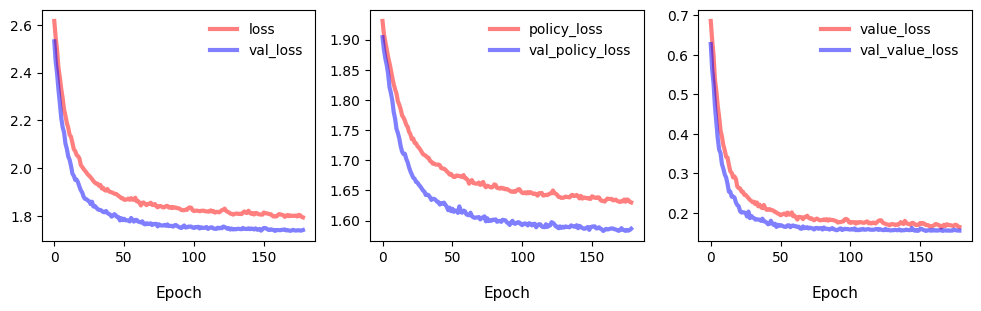

In [11]:

monitor_pairs = [["loss"       , "val_loss"],
                 ["policy_loss", "val_policy_loss"],
                 ["value_loss" , "val_value_loss"]]

num_axes = len(monitor_pairs)
fig      = plt.figure(figsize=(4*num_axes, 3))

for ax_idx, monitor_pair in enumerate(monitor_pairs) :
    
    ax  = fig.add_subplot(1, num_axes, 1+ax_idx)
    
    ax.plot(history.history[monitor_pair[0]], "-", lw=3, c="r", alpha=0.5, label=monitor_pair[0])
    ax.plot(history.history[monitor_pair[1]], "-", lw=3, c="b", alpha=0.5, label=monitor_pair[1])
    ax.legend(loc="upper right", frameon=False, fontsize=10)
    
    ax.set_xlabel("Epoch", labelpad=15, fontsize=11, ha="center", va="top")
    
plt.show(fig)
plt.close(fig)

In [12]:
##  Save model

'''new_model_name = f".neural_model_v1.h5"
new_model.save(new_model_name)'''


In [19]:
###
###  Play our bot
###

from connect4.utils import DebugLevel
from connect4.game  import BinaryPlayer, GameBoard
from connect4.bot   import Bot_NeuralMCTS, Bot_VanillaMCTS

bot_vanilla = Bot_VanillaMCTS(greedy=True)
bot_neural  = Bot_NeuralMCTS (new_model, greedy=True)

game_board = GameBoard()
print(game_board)

while not game_board.get_result() :
    if game_board.to_play == BinaryPlayer.X :
        print("OLD BOT TO PLAY:")
        bot = bot_vanilla
    else :
        print("NEW BOT TO PLAY:")
        bot = bot_neural
    action = bot.choose_action(game_board, duration=3, discount=0.99, debug_lvl=DebugLevel.LOW)
    game_board.apply_action(action)
    print(game_board)
    

+---+---+---+---+---+---+---+
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
+---+---+---+---+---+---+---+
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
+---+---+---+---+---+---+---+
Game result is: NONE
OLD BOT TO PLAY:
Selecting greedy action
Action values are:  0.018   0.065   0.059   0.196   -0.001  -0.070  0.038 
Visit counts are:   77      93      92      163     73      61      86    
Selecting action 3
+---+---+---+---+---+---+---+
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | X | . | . | . |
+---+---+---+---+---+---+---+
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
+---+---+---+---+---+---+---+
Game result is: NONE
NEW BOT TO PLAY:
Selecting greedy action
Action values are:  -0.342  -0.361  -0.255  -0.053  -0.334  -0.340  -0.402
Visit counts are:   10      15  

Selecting greedy action
Action values are:  0.127   -0.071  0.069   -0.408  0.102   -0.076  -0.032
Visit counts are:   183     79      140     33      157     81      91    
Selecting action 0
+---+---+---+---+---+---+---+
| . | . | . | . | . | . | . |
| . | . | . | O | . | . | . |
| . | X | . | O | . | . | . |
| . | O | O | X | . | . | . |
| X | X | X | O | . | . | . |
| O | X | X | X | O | . | . |
+---+---+---+---+---+---+---+
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
+---+---+---+---+---+---+---+
Game result is: NONE
NEW BOT TO PLAY:
Selecting greedy action
Action values are:  0.416   0.397   0.595   0.657   0.663   0.562   0.685 
Visit counts are:   14      11      43      207     128     11      185   
Selecting action 6
+---+---+---+---+---+---+---+
| . | . | . | . | . | . | . |
| . | . | . | O | . | . | . |
| . | X | . | O | . | . | . |
| . | O | O | X | . | . | . |
| X | X | X | O | . | . | . |
| O | X | X | X | O | . | O |
+---+---+---+---+---+---+---+
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
+---+-

Selecting greedy action
Action values are:  -0.414  -0.794  -0.783  -0.756
Visit counts are:   1207    103     108     120   
Selecting action 0
+---+---+---+---+---+---+---+
| X | O | O | O | . | . | . |
| O | X | X | O | . | . | . |
| X | X | O | O | . | . | . |
| X | O | O | X | . | . | . |
| X | X | X | O | X | . | . |
| O | X | X | X | O | . | O |
+---+---+---+---+---+---+---+
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
+---+---+---+---+---+---+---+
Game result is: NONE
NEW BOT TO PLAY:
Selecting greedy action
Action values are:  -0.565  0.822   0.749 
Visit counts are:   14      1192    45    
Selecting action 5
+---+---+---+---+---+---+---+
| X | O | O | O | . | . | . |
| O | X | X | O | . | . | . |
| X | X | O | O | . | . | . |
| X | O | O | X | . | . | . |
| X | X | X | O | X | . | . |
| O | X | X | X | O | O | O |
+---+---+---+---+---+---+---+
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
+---+---+---+---+---+---+---+
Game result is: NONE
OLD BOT TO PLAY:
Selecting greedy action
Action values are:  -0.582

Selecting greedy action
Action values are:  -0.801  0.990 
Visit counts are:   21      21500 
Selecting action 5
+---+---+---+---+---+---+---+
| X | O | O | O | . | O | O |
| O | X | X | O | . | X | O |
| X | X | O | O | . | X | X |
| X | O | O | X | . | O | O |
| X | X | X | O | X | X | X |
| O | X | X | X | O | O | O |
+---+---+---+---+---+---+---+
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
+---+---+---+---+---+---+---+
Game result is: NONE
OLD BOT TO PLAY:
Selecting greedy action
Action values are:  -0.990
Visit counts are:   26057 
Selecting action 4
+---+---+---+---+---+---+---+
| X | O | O | O | . | O | O |
| O | X | X | O | . | X | O |
| X | X | O | O | . | X | X |
| X | O | O | X | X | O | O |
| X | X | X | O | X | X | X |
| O | X | X | X | O | O | O |
+---+---+---+---+---+---+---+
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
+---+---+---+---+---+---+---+
Game result is: NONE
NEW BOT TO PLAY:
Selecting greedy action
Action values are:  1.000 
Visit counts are:   28133 
Selecting action 4
+---+---+---+---+